# Loading the data and required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
DIR = "E:/Coding/Summer 2023/data/"

In [4]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

Repartition data

In [10]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2)

Subsample non-readmitted patients to match size of readmitted ones

In [11]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [12]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

Sparse Matrix with word count

In [14]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenize_stem)
vect.fit(df_train['TEXT'].values)

X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)

y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']

Proportion of 1 in test sample

In [15]:
sum(y_test == 1) / sum(y_test == 0)

1.0

## Logistic Regression

In [16]:
grid = {'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]}

model_log = GridSearchCV(LogisticRegression(penalty='l2', max_iter=10000), param_grid=grid)

In [17]:
model_log.fit(X_train_tf, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]})

In [18]:
model_log.best_params_

{'C': 0.0001}

In [19]:
y_train_prob = model_log.predict_proba(X_train_tf)[:,1]
y_test_prob = model_log.predict_proba(X_test_tf)[:,1]

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [21]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7376585069444443 0.6916606986803127
Accuracy	 0.675 0.6305506216696269
Precission	 0.7007648183556405 0.6534446764091858
Recall		 0.6108333333333333 0.5559502664298401


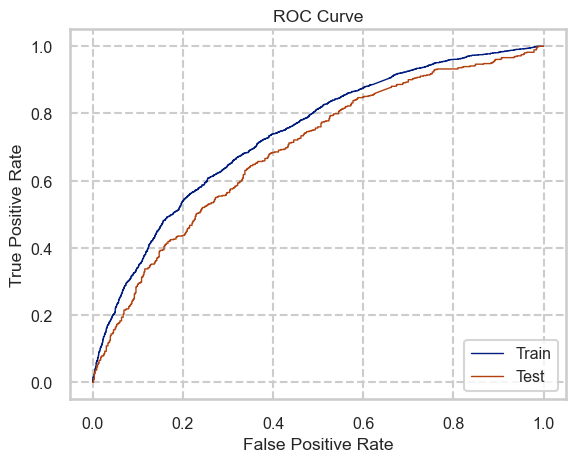

In [22]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/logistic_auroc.pgf')

## Ridge Regression

In [23]:
grid={'alpha': np.arange(10000, 20000, 1000)}
model_ridge = GridSearchCV(Ridge(), param_grid=grid)

In [24]:
model_ridge.fit(X_train_tf, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000])})

In [25]:
model_ridge.best_params_

{'alpha': 19000}

In [26]:
y_train_reg = model_ridge.predict(X_train_tf)
y_test_reg = model_ridge.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_reg)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_reg)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [28]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7697694444444444 0.6915502777874176
Accuracy	 0.6927083333333334 0.6323268206039077
Precission	 0.7246236036911122 0.6555323590814196
Recall		 0.6216666666666667 0.5577264653641207


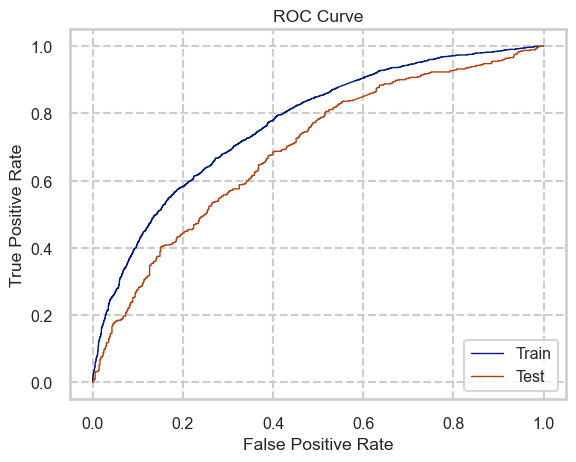

In [29]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/ridge_auroc.pgf')

## Lasso Regression

In [30]:
grid = {'alpha':[0.1,0.01,0.001,0.0001]}
model_lasso = GridSearchCV(Lasso(), param_grid=grid)

In [31]:
model_lasso.fit(X_train_tf, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.01, 0.001, 0.0001]})

In [32]:
model_lasso.best_params_

{'alpha': 0.01}

In [33]:
y_train_reg = model_lasso.predict(X_train_tf)
y_test_reg = model_lasso.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [35]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7376585069444443 0.6916606986803127
Accuracy	 0.67 0.6447602131438721
Precission	 0.6984435797665369 0.673773987206823
Recall		 0.5983333333333334 0.5612788632326821


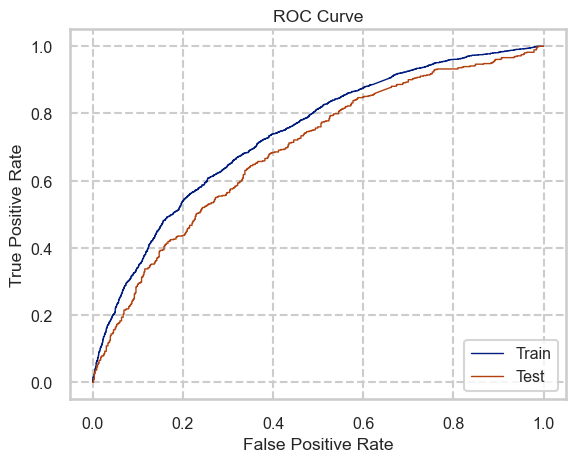

In [36]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/lasso_auroc.pgf')

## ElasticNet

In [37]:
np.arange(0.1, 1.0, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [40]:
grid = {
    #"max_iter": [1, 2, 3, 4, 5],
    "alpha": [0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.1, 1.0, 0.1)
}
model_enet = GridSearchCV(ElasticNet(), param_grid=grid)

In [41]:
model_enet.fit(X_train_tf, y_train)

In [ ]:
model_enet.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [ ]:
y_train_prob = model_enet.predict(X_train_tf)
y_test_prob = model_enet.predict(X_test_tf)

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [ ]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7399305223673801 0.6955031693699028
Accuracy	 0.674749498997996 0.6421725239616614
Precission	 0.7114451988360815 0.6660447761194029
Recall		 0.5879759519038076 0.5702875399361023


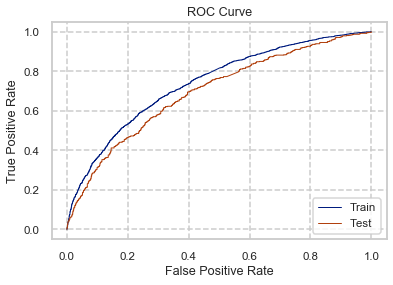

In [ ]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('fig/elastic_auroc.pgf')